# DBN Model for Stock Price Prediction

This document provides an overview of the implementation of a Deep Belief Network (DBN) for predicting stock prices based on historical price data. Unlike traditional neural networks, DBNs are composed of multiple layers of stochastic, latent variables, typically structured as Restricted Boltzmann Machines (RBMs) stacked on top of each other. This architecture is especially suited for capturing complex patterns in data through a layer-by-layer unsupervised learning process before a final supervised tuning, making it effective for tasks such as feature extraction and regression in time series forecasting.

## Model Architecture

The DBN model implemented in PyTorch encompasses several layers designed to optimize the extraction and utilization of features from stock price data:

- **Restricted Boltzmann Machines (RBMs)**: Utilized as the building blocks of the DBN, each RBM in the network learns a set of features based on inputs from the previous layer, effectively encoding more abstract representations of the data as layers progress.
- **Input Layer**: Accepts normalized sequences of historical stock prices, which are then processed through multiple layers of RBMs.
- **Output Layer**: After pre-training through the RBMs, a final output layer, often a regression or logistic layer, is trained to predict future stock prices based on the features learned by the DBN.
- **Loss Function and Optimizer**: The network typically uses a Mean Squared Error (MSE) for regression tasks to quantify prediction accuracy and employs optimizers like Adam or SGD for fine-tuning the weights in the supervised phase.

## Forecasting Process

Forecasting with a DBN involves a multi-phase training approach:

1. **Data Preparation**: Stock data is scaled using normalization techniques to ensure it is suitable for the sensitive dynamics of a DBN.
2. **Model Initialization**: Parameters including the size of each RBM layer and the learning rates are configured to tailor the DBN architecture to the specifics of the stock price data.
3. **Unsupervised Pre-training**: Each RBM is trained sequentially to learn a hierarchy of features from the raw input data, with each layer capturing increasingly abstract representations.
4. **Supervised Fine-tuning**: Following the unsupervised pre-training, the entire network undergoes a supervised training phase to fine-tune the weights based on the actual forecasting task.
5. **Evaluation**: The trained model is then evaluated on a separate set of test data to assess its predictive performance and generalization capability.
6. **Visualization**: Tools such as Matplotlib or Plotly are used to graphically represent the prediction results alongside actual stock prices for a comprehensive performance review.

## Multiple Simulations

The robustness of the DBN model can be assessed through multiple simulations:

1. **Repeatability**: The model is trained and evaluated multiple times with different initializations to test the consistency of its predictions.
2. **Performance Analysis**: Observing variations in performance across different simulations provides insight into the model's reliability and helps identify areas for potential enhancement.

## Usage Instructions

To employ the DBN model for stock price forecasting, follow these steps:

1. **Load Data**: Import the dataset containing historical stock price information.
2. **Set Model Parameters**: Adjust the model settings, such as the number of layers and neurons in each RBM, according to your analysis requirements.
3. **Prepare Data**: Normalize the dataset and organize it into a suitable format for training.
4. **Instantiate and Train the Model**: Construct an instance of the DBN and perform both the pre-training and fine-tuning phases.
5. **Evaluate and Visualize**: After training, evaluate the model's effectiveness on test data and use visualization tools to compare predicted results against actual historical prices.

## Requirements

- Python 3.x
- PyTorch
- NumPy
- Matplotlib or Plotly

The DBN model offers a sophisticated and powerful approach for financial analysts and data scientists aiming to leverage deep learning for stock price forecasting. By learning multiple layers of features, the DBN can uncover intricate patterns in historical data, supporting precise and informed predictions crucial for effective trading strategies.

In [7]:
# !pip install yfinance tensorflow keras numpy matplotlib seaborn tqdm scikit-learn graphviz

In [1]:
from utils import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import plotly.graph_objects as go


# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [10]:
# stock configs
ticker = ['TSLA']
start_date = '2014-04-01'
end_date = '2024-04-05'

In [11]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(2520, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2014-04-01,13.934667,14.544000,13.905333,14.464667,110571000,0.0,0.0
1,2014-04-02,14.666667,15.392667,14.536667,15.352667,161734500,0.0,0.0
2,2014-04-03,15.353333,15.715333,14.800000,15.026667,163855500,0.0,0.0
3,2014-04-04,15.067333,15.218000,14.083333,14.148667,170184000,0.0,0.0
4,2014-04-07,13.720667,14.413333,13.567333,13.834667,147832500,0.0,0.0


# Model Implementation

Below we implement the model, first we separate the data into a train-test split.  For this LSTM model, we will leverage continuous windows of time for training and test data.


In [85]:
# Normalize the 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale the data between 0 and 1 for DBN 
df_scaled = scaler.fit_transform(data[['Close']].astype('float32'))
df_scaled = pd.DataFrame(df_scaled, columns=['Close'])

# Define parameters
lookback = 30
train_size = 0.8
total_size = df_scaled.shape[0]
train_len = int(total_size * train_size)
test_len = total_size - train_len

# Split into train and test sets
df_train = df_scaled.iloc[:train_len]
df_test = df_scaled.iloc[train_len:]

# Function to create dataset
def create_dataset(X, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(X[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Prepare training and testing data
X_train, y_train = create_dataset(df_train.values, lookback)
X_test, y_test = create_dataset(df_test.values, lookback)

In [86]:
# Frist we need to implement the Restricted Boltzmann Machine, which is the building block of the Deep Belief Network
class RBM(nn.Module):
    def __init__(self, n_visible, n_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hidden, n_visible) * 1e-2)
        self.a = nn.Parameter(torch.zeros(n_visible))  # Visible biases
        self.b = nn.Parameter(torch.zeros(n_hidden))   # Hidden biases

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(torch.matmul(v, self.W.t()) + self.b)
        sample_h = self.sample_from_p(p_h)
        return p_h, sample_h

    def h_to_v(self, h):
        p_v = torch.sigmoid(torch.matmul(h, self.W) + self.a)
        sample_v = self.sample_from_p(p_v)
        return p_v, sample_v

    def forward(self, v):
        pre_h1, h1 = self.v_to_h(v)
        pre_v, v1 = self.h_to_v(h1)
        return v1

    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.a)
        wx_b = torch.matmul(v, self.W.t()) + self.b
        hidden_term = torch.sum(torch.log(1 + torch.exp(wx_b)), dim=1)
        return (-hidden_term - vbias_term).mean()

In [97]:
class DBN(nn.Module):
    def __init__(self, n_visible, hidden_layers):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList()
        self.optimizers = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for i in range(len(hidden_layers) - 1):
            self.rbms = nn.ModuleList()
            self.optimizers = []

            # Ensure correct linking of layers
            prev_layer_size = n_visible
            for hidden_size in hidden_layers:
                rbm = RBM(30, 30)
                self.rbms.append(rbm)
                self.optimizers.append(optim.Adam(rbm.parameters(), lr=0.01))
                prev_layer_size = hidden_size

    def forward(self, v):
        for rbm in self.rbms:
            _, v = rbm.v_to_h(v)
        return v

    def train_static(self, data, epochs=10, batch_size=10):
        train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        for epoch in range(epochs):
            for _, data_batch in enumerate(train_loader):
                data_batch = data_batch.float()  # Make sure data is float
                v = data_batch.to(self.device)
                for rbm, optimizer in zip(self.rbms, self.optimizers):
                    optimizer.zero_grad()
                    v1 = rbm(v)
                    loss = rbm.free_energy(v) - rbm.free_energy(v1.detach())
                    loss.backward()
                    optimizer.step()
                    v = v1.detach()
                print(f'Epoch {epoch+1}, Loss {loss.item()}')

    
    



In [98]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [99]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 20
dropout_rate = 0.8
future_day = 60
learning_rate = 0.01

In [100]:
def forecast_dbn(model, X_train, X_test):
    # Assuming the model is already trained, we just run forward inference.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        test_pred = model.forward(X_test_tensor)

    return test_pred.cpu().numpy().flatten()


In [101]:
def run_model_iterations(n_iterations, X_train, y_train, X_test):
    predictions = []
    for _ in range(n_iterations):
        # Initialize the model
        model = DBN(n_visible=1, hidden_layers=[30, 64])  # Adjust hidden layers as needed
        
        # Train the model
        model.train_static(X_train, epochs=50, batch_size=30)  # Make sure to pass appropriate data
        
        # Predict
        preds = forecast_dbn(model, X_train, X_test)
        arr = scaler.inverse_transform(preds.reshape(-1, 1)).tolist()
        arr = [p[0] if isinstance(p, list) else p for p in arr]
        predictions.append(arr)
    
    return predictions


In [102]:
# Run the model multiple times
from datetime import datetime, timedelta 
n_iterations = 5
test_start_date = datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=test_len - 1)
model_predictions = run_model_iterations(5, X_train, y_train, X_test)  # 5 iterations
actual_data = y_test.flatten()
dates = pd.date_range(start=test_start_date, periods=len(y_test), freq='D')


Epoch 1, Loss 0.032489776611328125
Epoch 1, Loss 0.09181785583496094
Epoch 1, Loss 0.11600303649902344
Epoch 1, Loss -0.00545501708984375
Epoch 1, Loss 0.47997474670410156
Epoch 1, Loss -0.42980384826660156
Epoch 1, Loss -0.6406688690185547
Epoch 1, Loss -0.6097431182861328
Epoch 1, Loss -1.2103004455566406
Epoch 1, Loss -1.5293846130371094
Epoch 1, Loss -1.7911882400512695
Epoch 1, Loss -2.762101173400879
Epoch 1, Loss -2.706845283508301
Epoch 1, Loss -2.970273971557617
Epoch 1, Loss -2.7579002380371094
Epoch 1, Loss -3.5221385955810547
Epoch 1, Loss -2.6404151916503906
Epoch 1, Loss -3.0380802154541016
Epoch 1, Loss -3.673933982849121
Epoch 1, Loss -3.4474382400512695
Epoch 1, Loss -2.6058826446533203
Epoch 1, Loss -1.6512632369995117
Epoch 1, Loss -2.4053497314453125
Epoch 1, Loss -1.688368797302246
Epoch 1, Loss -1.3342523574829102
Epoch 1, Loss -1.883040428161621
Epoch 1, Loss -1.0921764373779297
Epoch 1, Loss -1.5328607559204102
Epoch 1, Loss -1.2104969024658203
Epoch 1, Loss -3.

In [103]:
model_predictions = [[0] * 30 + pred for pred in model_predictions]
print(model_predictions[0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.57800006866455, 409.9700012207031, 409.9700012207031, 409.9700012207031, 9.57800006866455, 409.9700012207031, 409.9700012207031, 9.57800006866455, 9.57800006866455, 409.9700012207031, 9.57800006866455, 409.9700012207031, 9.57800006866455, 409.9700012207031, 409.9700012207031, 9.57800006866455, 409.9700012207031, 409.9700012207031, 9.57800006866455, 409.9700012207031, 9.57800006866455, 409.9700012207031, 9.57800006866455, 9.57800006866455, 409.9700012207031, 409.9700012207031, 9.57800006866455, 409.9700012207031, 409.9700012207031, 9.57800006866455, 409.9700012207031, 409.9700012207031, 9.57800006866455, 9.57800006866455, 409.9700012207031, 9.57800006866455, 9.57800006866455, 9.57800006866455, 409.9700012207031, 409.9700012207031, 409.9700012207031, 9.57800006866455, 409.9700012207031, 9.57800006866455, 409.9700012207031, 9.57800006866455, 9.57800006866455, 409.9700012207031, 409.9700012207031, 

In [106]:

# Creating traces for the actual and predicted stock prices
trace_actual = go.Scatter(
    x=dates,
    y=data['Close'].iloc[train_len:].values,
    mode='lines',
    name='Actual Price',
    line=dict(color='blue', width=2)
)

traces_predicted = []
for i, preds in enumerate(model_predictions):
    trace_predicted = go.Scatter(
        x=dates,
        y=preds,
        mode='lines',
        name=f'Predicted Price (Iteration {i+1})',
        line=dict(color=f'rgba(255, 0, 0, {1 - i*0.12})', dash='dot', width=2)  # Adjust opacity for clarity
    )
    traces_predicted.append(trace_predicted)

# Create the layout and figure
layout = go.Layout(
    title='Stock Price Prediction (During Test Period)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    template='plotly_dark'
)

fig = go.Figure(data=[trace_actual] + traces_predicted, layout=layout)
fig.show()

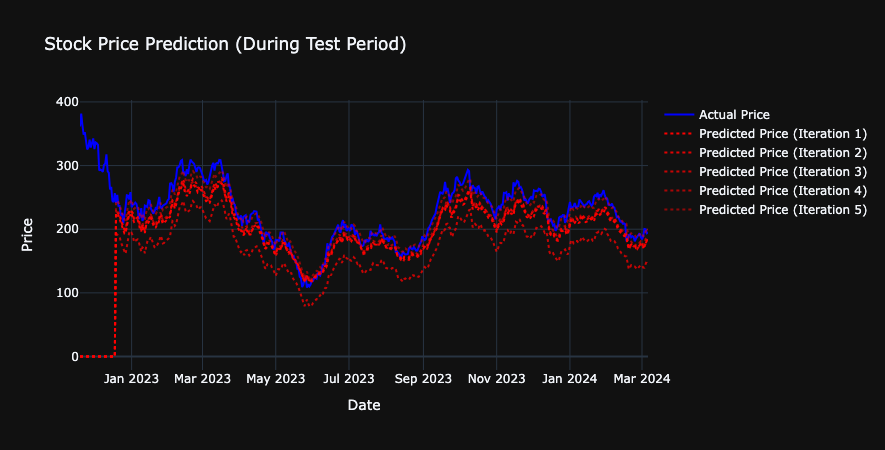